In [1]:
import numpy as np              # numpy is a general-purpose math package
import yt                       # yt is the data vizualization package
from yt.units import *          # this lets you get things like speed of light in proper units just by typing 'c'
from astropy.table import Table # this is needed for reading in various foggie data byproducts
from astropy.io import ascii    # this too
import matplotlib.pyplot as plt # this is the standard python plotting package, very useful!
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import math
from ipynb.fs.defs.FRB_and_Projection_functions import frb_projection, projection
from scipy import optimize
import pwlf # A library for fitting continuous piecewise linear functions to data (Returns cut-off radius)
import os #for the lacie part 

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.foggie_load import *

home_dir = '/Users/hylee/foggie/'
laptop_root_dir = home_dir + 'foggie_sims/' # root directory where sims are stored on the laptop
hd_root_dir = '/Volumes/LaCie/' # root directory where sims are stored on the hard drive

root_dir = hd_root_dir # have this as either laptop_root_dir or hd_root_dir depending on where the simulation is stored
code_path = '/Users/hylee/coding/foggie/foggie/' #path to the cloned github repo

# everything above this is general path, and below this is specific to a given halo
halo = '8508' # which halo
simulation_dir = root_dir + 'halo_00' + halo + '/nref11c_nref9f/' # path where the foggie simulations are stored
output_dir = home_dir + 'foggie_output/halo_00' + halo + '/nref11c_nref9f/' # path where all the outputs will be stored
track_dir = code_path + 'halo_infos/00' + halo + '/nref11c_nref9f/'
track_name = code_path + 'halo_tracks/00' + halo + '/nref11n_selfshield_15/halo_track_200kpc_nref9' #these need to be provided to foggie_load()

In [2]:
def radius_func(od, size, res):
    OD_Qua=[]
    OD_Rad=[]  #OD_Rad & OD_Met HAVE to be defined specifically inside func1/before for loop
    for i in range(70):
        for j in range(70):
            this_quantity_value = od[i][j]
            xindex = i
            yindex = j
            radius = (math.sqrt(((yindex-34)**2+(xindex-34)**2)))*(size/res)
            OD_Qua.append(this_quantity_value)
            OD_Rad.append(radius)
    return OD_Rad, OD_Qua

In [3]:
def binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize):
    index = 0 
    quantitylist = []
    sort = np.argsort(OD_Rad)
    sorted_radius = np.array(OD_Rad)[sort]
    sorted_quantity = np.array(OD_Qua)[sort]
    radiuslist = np.arange(min_radius, max_radius, binsize) + binsize/2
    while index < len(radiuslist):
        left_edge = index*binsize
        right_edge = left_edge + binsize 
        new_quantity = np.array(sorted_quantity)[(left_edge <= sorted_radius) & (sorted_radius < right_edge)]
        quantitylist.append((np.mean(new_quantity)))
        index +=1
    return radiuslist, quantitylist

In [4]:
def piecewise_linear(x, x0, y0, k1, k2): 
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

In [5]:
def plotting(xvalue, yvalue_origdata, yvalue_cutoff, color_original, color_cutoff, plotlabel_linedot,
            plotlabel_segment):
    fig1 = plt.figure()
    plt.plot(xvalue, yvalue_origdata, color_original, label=plotlabel_linedot)
    plt.plot(xvalue, yvalue_cutoff, color_cutoff, label=plotlabel_segment)
    plt.legend(loc="upper right", fontsize = 15)
    plt.xlabel("Radius from galactic center [kpc]", fontsize = fontsize)
    plt.ylabel("Density [log 10 g/cm^2]", fontsize = fontsize)
    plt.xticks(fontsize = fontsize/1.5)
    plt.yticks(fontsize = fontsize/1.5)
    return fig1

In [6]:
DDLIST = []
for file in os.listdir(simulation_dir):
    if file.startswith("DD"):
        DDLIST.append(file)
sorted_dd_list = sorted(DDLIST, key=lambda x: int(x[2:]))

In [7]:
field = "density"
axis = "y" 
resolution = 70 #[pixel]
colorlabel = 'Density [log 10 g/cm^2]'
min_radius = 0  #[kpc]
binsize = 1.5 #[kpc]
markersize = 10
fontsize = 20 
plotlabel_linedot = 'Binned mean density'

yt : [INFO     ] 2023-07-21 15:00:51,509 Parameters: current_time              = 67.566527818285
yt : [INFO     ] 2023-07-21 15:00:51,510 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:00:51,510 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:00:51,511 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:00:51,511 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:00:51,512 Parameters: current_redshift          = 4.2560468529995
yt : [INFO     ] 2023-07-21 15:00:51,513 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:00:51,513 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:00:51,514 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:00:51,514 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0138/DD0138
get_refine_box: using this location:     col1      col2     col3     col4     col5     col6     col7   col8
----------- -------- -------- -------- -------- -------- -------- ----
4.256046853 0.494908 0.492937 0.500048 0.496908 0.494937 0.502048    9


Parsing Hierarchy : 100%|█████████████████| 5116/5116 [00:00<00:00, 9893.49it/s]
yt : [INFO     ] 2023-07-21 15:00:52,280 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:01:59,410 Projection completed
yt : [INFO     ] 2023-07-21 15:01:59,413 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/var/folders/d8/fhyrhkwj0gn9mv61yhxy4srw0005m7/T/ipykernel_64060/2418151696.py:29: RuntimeWarning: divide by zero encountered in log10
  p , e = optimize.curve_fit(piecewise_linear, radiuslist, np.log10(quantitylist), p0 = [20,1,1,1])
yt : [INFO     ] 2023-07-21 15:01:59,518 Parameters: current_time              = 92.566527818285
yt : [INFO     ] 2023-07-21 15:01:59,519 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:01:59,519 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:01:59,520 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:01:59,521 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:01:59,521 Parameters: current_redshift          = 3.2538800161868
yt : [INFO     ] 2023-07-21 15:01:59,522

Error with DD0138
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0238/DD0238
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
3.25388001619 0.494301 0.491267 0.500132 0.496301 0.493267 0.502132    9


Parsing Hierarchy : 100%|██████████████| 11675/11675 [00:01<00:00, 10602.36it/s]
yt : [INFO     ] 2023-07-21 15:02:01,025 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:04:15,865 Projection completed
yt : [INFO     ] 2023-07-21 15:04:15,867 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


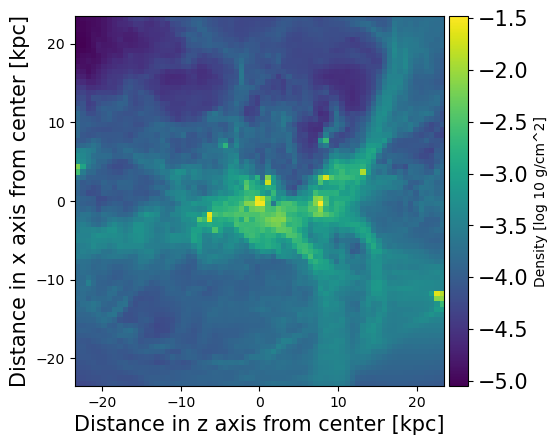

yt : [INFO     ] 2023-07-21 15:04:16,448 Parameters: current_time              = 104.81652781829
yt : [INFO     ] 2023-07-21 15:04:16,449 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:04:16,449 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:04:16,450 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:04:16,451 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:04:16,451 Parameters: current_redshift          = 2.9116806075987
yt : [INFO     ] 2023-07-21 15:04:16,452 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:04:16,452 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:04:16,453 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:04:16,454 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0287/DD0287
get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
2.9116806076 0.493954 0.490721 0.500203 0.495954 0.492721 0.502203    9


Parsing Hierarchy : 100%|████████████████| 7384/7384 [00:00<00:00, 11385.88it/s]
yt : [INFO     ] 2023-07-21 15:04:17,349 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:05:37,031 Projection completed
yt : [INFO     ] 2023-07-21 15:05:37,032 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


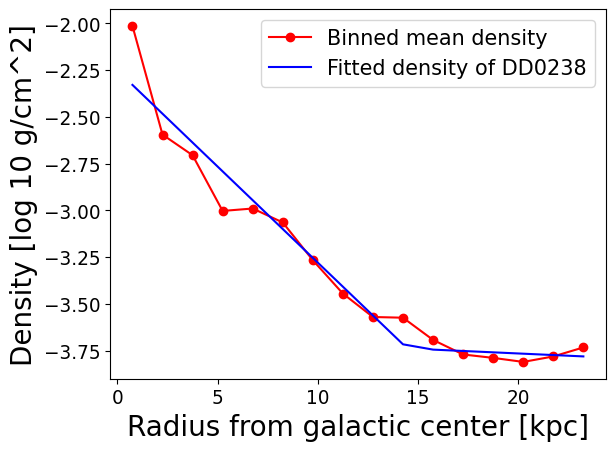

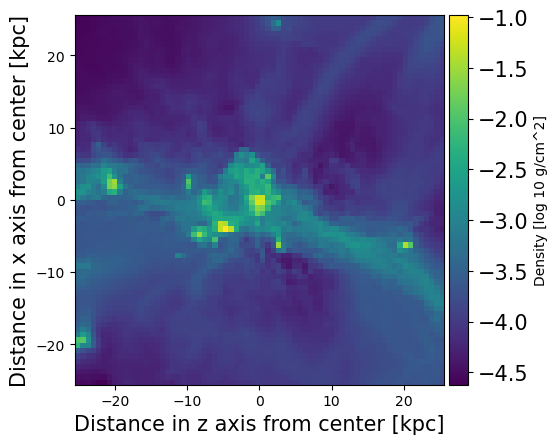

yt : [INFO     ] 2023-07-21 15:05:37,590 Parameters: current_time              = 106.31652781829
yt : [INFO     ] 2023-07-21 15:05:37,591 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:05:37,591 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:05:37,592 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:05:37,593 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:05:37,593 Parameters: current_redshift          = 2.8742891413864
yt : [INFO     ] 2023-07-21 15:05:37,594 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:05:37,595 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:05:37,596 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:05:37,596 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0293/DD0293
get_refine_box: using this location:      col1       col2     col3     col4    col5     col6     col7  col8
------------- -------- -------- ------- -------- -------- ------- ----
2.87428914139 0.493962 0.490687 0.50017 0.495962 0.492687 0.50217    9


Parsing Hierarchy : 100%|█████████████████| 7297/7297 [00:01<00:00, 5078.70it/s]
yt : [INFO     ] 2023-07-21 15:05:39,368 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:07:01,890 Projection completed
yt : [INFO     ] 2023-07-21 15:07:01,891 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


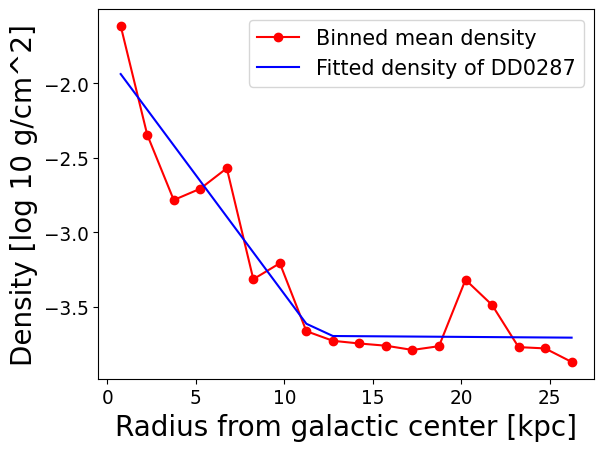

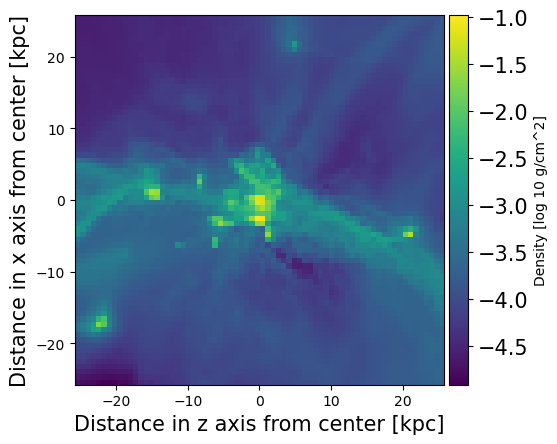

yt : [INFO     ] 2023-07-21 15:07:02,552 Parameters: current_time              = 117.56652781829
yt : [INFO     ] 2023-07-21 15:07:02,553 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:07:02,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:07:02,555 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:07:02,555 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:07:02,556 Parameters: current_redshift          = 2.6192132579666
yt : [INFO     ] 2023-07-21 15:07:02,557 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:07:02,558 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:07:02,558 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:07:02,559 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0338/DD0338
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.61921325797 0.493773 0.490067 0.500353 0.495773 0.492067 0.502353    9


Parsing Hierarchy : 100%|█████████████████| 8624/8624 [00:01<00:00, 8109.17it/s]
yt : [INFO     ] 2023-07-21 15:07:04,049 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:08:41,050 Projection completed
yt : [INFO     ] 2023-07-21 15:08:41,053 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


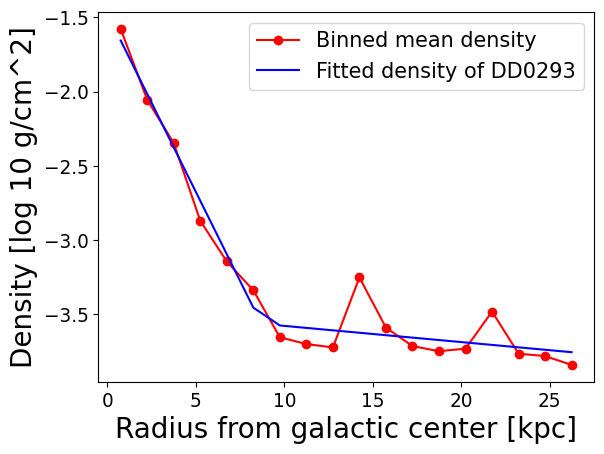

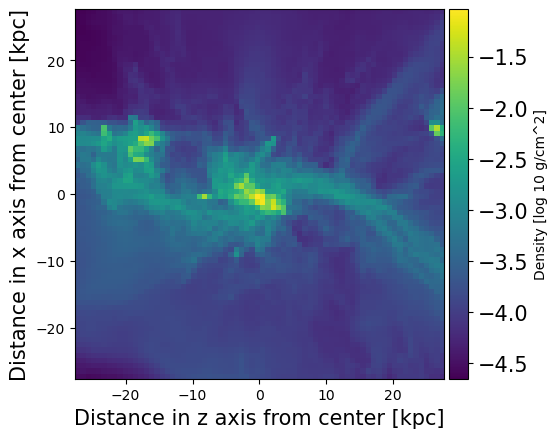

yt : [INFO     ] 2023-07-21 15:08:41,733 Parameters: current_time              = 142.56652781829
yt : [INFO     ] 2023-07-21 15:08:41,734 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:08:41,734 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:08:41,735 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:08:41,736 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:08:41,736 Parameters: current_redshift          = 2.174064272558
yt : [INFO     ] 2023-07-21 15:08:41,737 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:08:41,737 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:08:41,738 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:08:41,738 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0438/DD0438
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.17406427256 0.493252 0.488579 0.500941 0.495252 0.490579 0.502941    9


Parsing Hierarchy : 100%|█████████████████| 9619/9619 [00:01<00:00, 9322.43it/s]
yt : [INFO     ] 2023-07-21 15:08:43,142 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:10:16,277 Projection completed
yt : [INFO     ] 2023-07-21 15:10:16,278 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


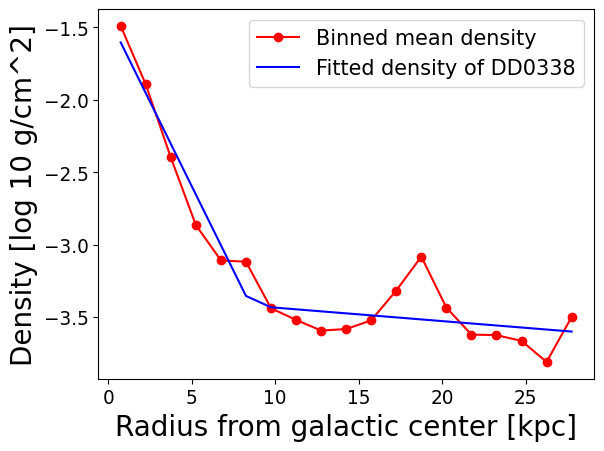

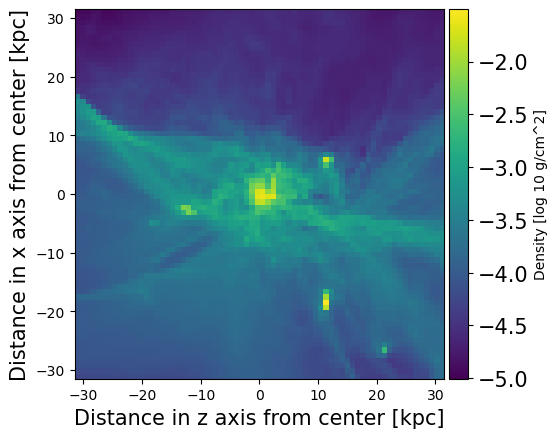

yt : [INFO     ] 2023-07-21 15:10:16,886 Parameters: current_time              = 167.56652781829
yt : [INFO     ] 2023-07-21 15:10:16,886 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:10:16,887 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:10:16,888 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:10:16,888 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:10:16,889 Parameters: current_redshift          = 1.8407728906142
yt : [INFO     ] 2023-07-21 15:10:16,889 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:10:16,890 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:10:16,890 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:10:16,891 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0538/DD0538
get_refine_box: using this location:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
1.84077289061 0.492796 0.487204 0.501442 0.494796 0.489204 0.503442    9


Parsing Hierarchy : 100%|█████████████████| 6003/6003 [00:00<00:00, 6603.97it/s]
yt : [INFO     ] 2023-07-21 15:10:18,011 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:11:15,222 Projection completed
yt : [INFO     ] 2023-07-21 15:11:15,224 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


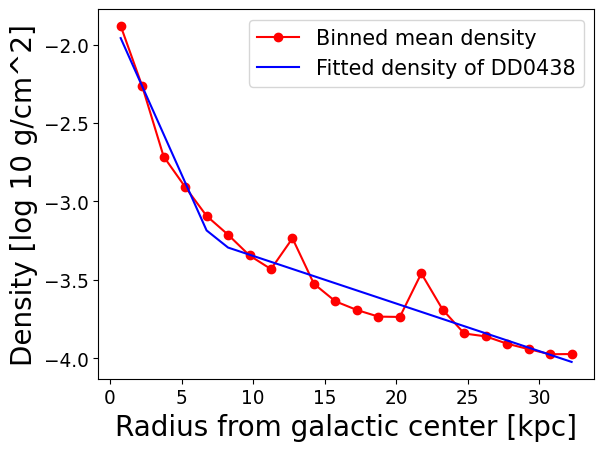

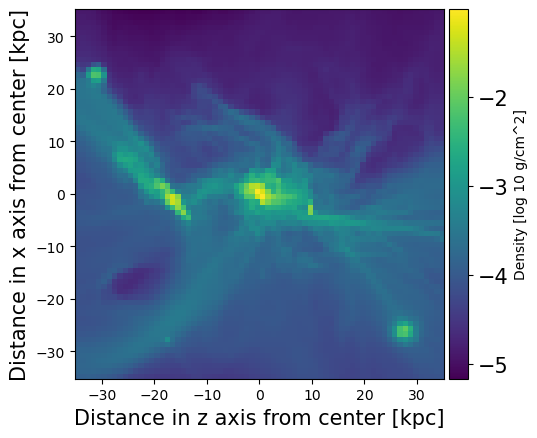

yt : [INFO     ] 2023-07-21 15:11:15,769 Parameters: current_time              = 192.56652781829
yt : [INFO     ] 2023-07-21 15:11:15,770 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:11:15,770 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:11:15,771 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:11:15,771 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:11:15,772 Parameters: current_redshift          = 1.5796008591072
yt : [INFO     ] 2023-07-21 15:11:15,773 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:11:15,774 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:11:15,774 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:11:15,775 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0638/DD0638
get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.57960085911 0.49248 0.485831 0.501973 0.49448 0.487831 0.503973    9


Parsing Hierarchy : 100%|█████████████████| 7363/7363 [00:01<00:00, 5372.76it/s]
yt : [INFO     ] 2023-07-21 15:11:17,468 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:12:29,423 Projection completed
yt : [INFO     ] 2023-07-21 15:12:29,424 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


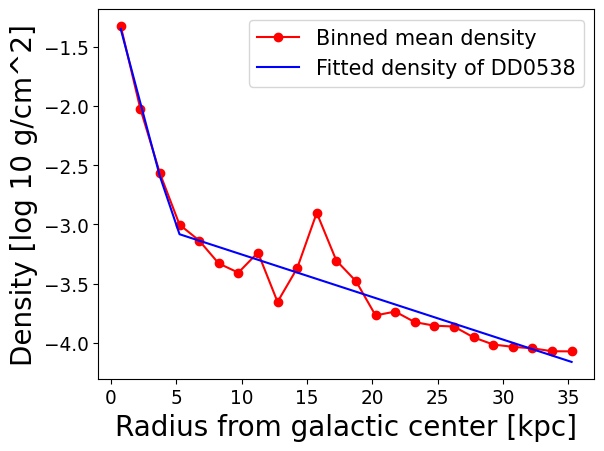

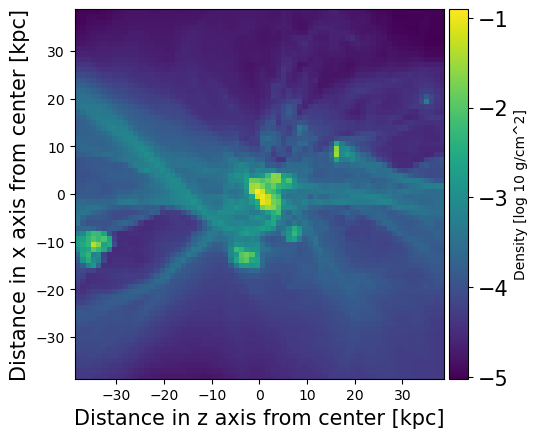

yt : [INFO     ] 2023-07-21 15:12:30,060 Parameters: current_time              = 217.56652781829
yt : [INFO     ] 2023-07-21 15:12:30,061 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:12:30,061 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:12:30,062 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:12:30,063 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:12:30,063 Parameters: current_redshift          = 1.3679320867642
yt : [INFO     ] 2023-07-21 15:12:30,064 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:12:30,064 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:12:30,065 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:12:30,065 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0738/DD0738
get_refine_box: using this location:      col1       col2    col3     col4    col5    col6     col7  col8
------------- ------- -------- ------- ------- -------- ------- ----
1.36793208676 0.49219 0.484532 0.50256 0.49419 0.486532 0.50456    9


Parsing Hierarchy : 100%|█████████████████| 8207/8207 [00:00<00:00, 9880.85it/s]
yt : [INFO     ] 2023-07-21 15:12:31,676 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:13:48,732 Projection completed
yt : [INFO     ] 2023-07-21 15:13:48,733 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


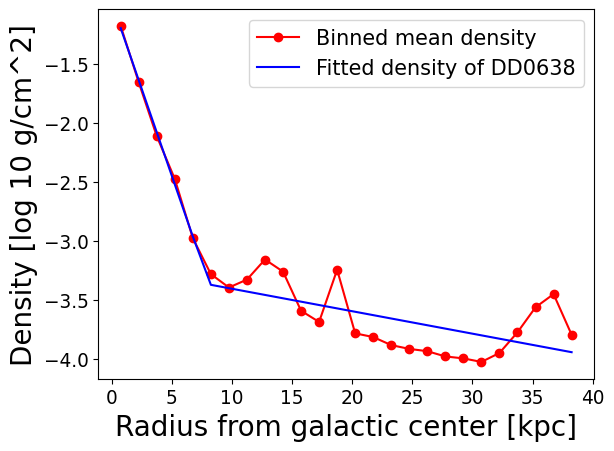

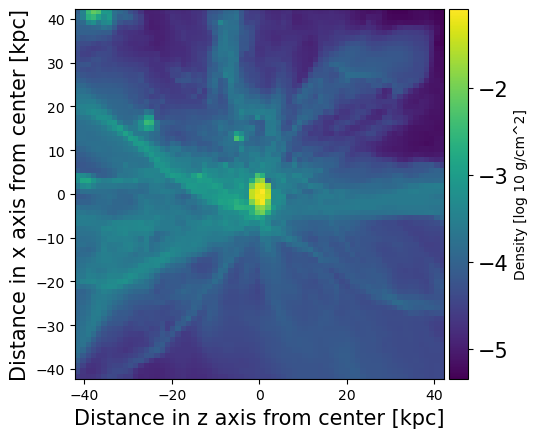

yt : [INFO     ] 2023-07-21 15:13:49,350 Parameters: current_time              = 242.56652781829
yt : [INFO     ] 2023-07-21 15:13:49,350 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:13:49,351 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:13:49,351 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:13:49,352 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:13:49,353 Parameters: current_redshift          = 1.1918720434881
yt : [INFO     ] 2023-07-21 15:13:49,354 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:13:49,354 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:13:49,355 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:13:49,355 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0838/DD0838
get_refine_box: using this location:      col1       col2    col3     col4     col5    col6     col7   col8
------------- ------- -------- -------- ------- -------- -------- ----
1.19187204349 0.49185 0.483393 0.503033 0.49385 0.485393 0.505033    9


Parsing Hierarchy : 100%|█████████████████| 6414/6414 [00:00<00:00, 9278.02it/s]
yt : [INFO     ] 2023-07-21 15:13:50,285 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:14:54,422 Projection completed
yt : [INFO     ] 2023-07-21 15:14:54,423 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


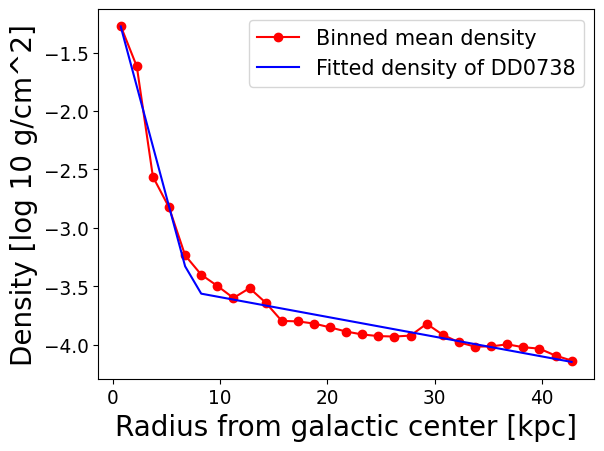

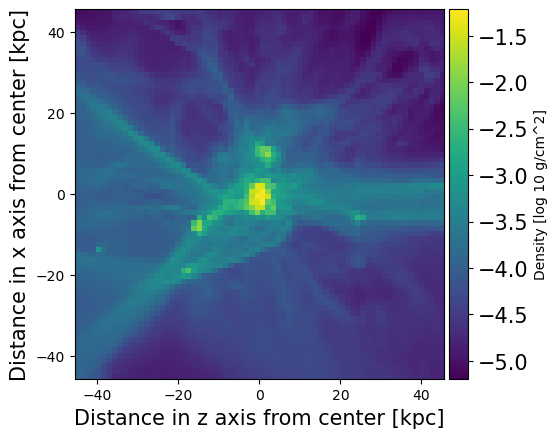

yt : [INFO     ] 2023-07-21 15:14:55,016 Parameters: current_time              = 267.56652781829
yt : [INFO     ] 2023-07-21 15:14:55,016 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:14:55,017 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:14:55,018 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:14:55,019 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:14:55,020 Parameters: current_redshift          = 1.0423765498971
yt : [INFO     ] 2023-07-21 15:14:55,020 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:14:55,021 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:14:55,022 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:14:55,022 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD0938/DD0938
get_refine_box: using this location:     col1       col2     col3     col4     col5     col6     col7   col8
------------ -------- -------- -------- -------- -------- -------- ----
1.0423765499 0.491558 0.482256 0.503483 0.493558 0.484256 0.505483    9


Parsing Hierarchy : 100%|█████████████████| 6646/6646 [00:00<00:00, 7323.24it/s]
yt : [INFO     ] 2023-07-21 15:14:56,157 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:16:03,026 Projection completed
yt : [INFO     ] 2023-07-21 15:16:03,027 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


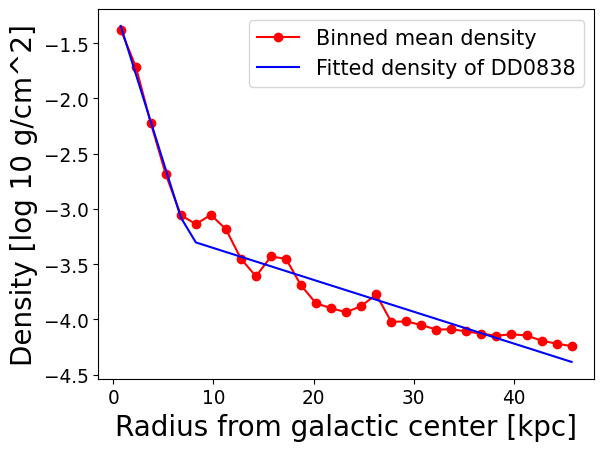

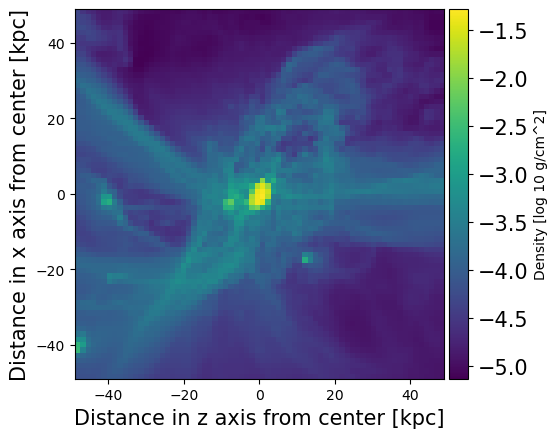

yt : [INFO     ] 2023-07-21 15:16:03,795 Parameters: current_time              = 292.31652781829
yt : [INFO     ] 2023-07-21 15:16:03,795 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:16:03,796 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:16:03,797 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:16:03,798 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:16:03,798 Parameters: current_redshift          = 0.91449134314195
yt : [INFO     ] 2023-07-21 15:16:03,799 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:16:03,800 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:16:03,801 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:16:03,801 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1038/DD1038
get_refine_box: using this location:      col1        col2     col3     col4     col5     col6     col7   col8
-------------- -------- -------- -------- -------- -------- -------- ----
0.914491343142 0.491324 0.481173 0.503918 0.493324 0.483173 0.505918    9


Parsing Hierarchy : 100%|█████████████████| 5369/5369 [00:00<00:00, 5806.32it/s]
yt : [INFO     ] 2023-07-21 15:16:05,369 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:16:52,383 Projection completed
yt : [INFO     ] 2023-07-21 15:16:52,384 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


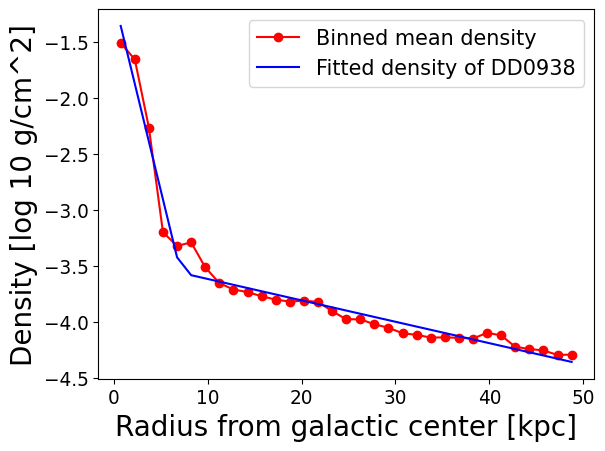

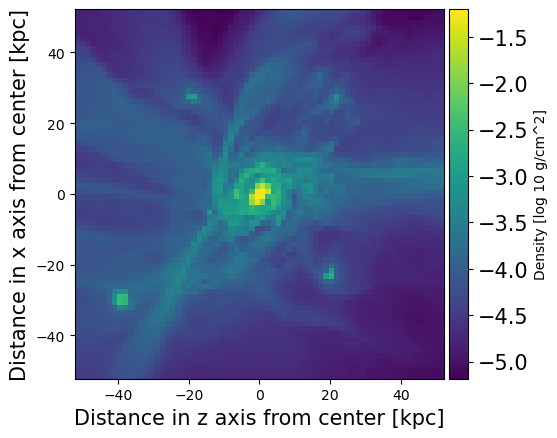

yt : [INFO     ] 2023-07-21 15:16:52,871 Parameters: current_time              = 317.31652781829
yt : [INFO     ] 2023-07-21 15:16:52,872 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:16:52,872 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:16:52,873 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:16:52,874 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:16:52,875 Parameters: current_redshift          = 0.80131183964773
yt : [INFO     ] 2023-07-21 15:16:52,875 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:16:52,876 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:16:52,876 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:16:52,877 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1138/DD1138
get_refine_box: using this location:       col1         col2    col3    col4     col5    col6    col7   col8
---------------- ------- ------- -------- ------- ------- -------- ----
0.80131183964773 0.49111 0.48016 0.504261 0.49311 0.48216 0.506261    9


Parsing Hierarchy : 100%|█████████████████| 5629/5629 [00:00<00:00, 8627.42it/s]
yt : [INFO     ] 2023-07-21 15:16:53,752 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:17:41,494 Projection completed
yt : [INFO     ] 2023-07-21 15:17:41,496 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


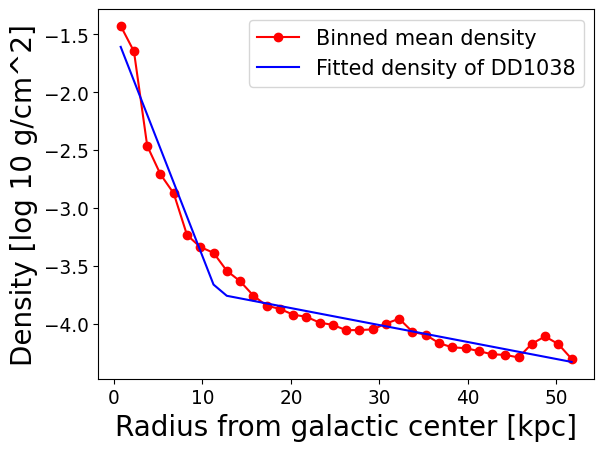

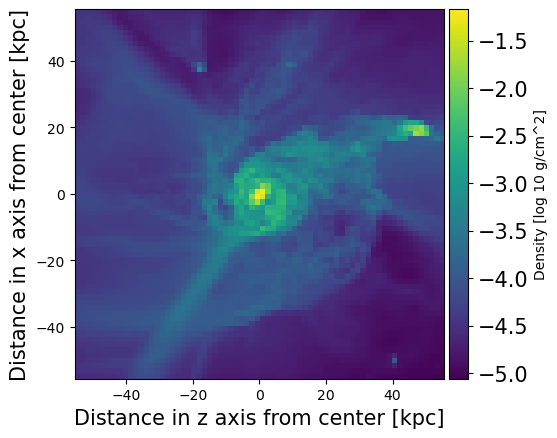

yt : [INFO     ] 2023-07-21 15:17:42,024 Parameters: current_time              = 342.31652781829
yt : [INFO     ] 2023-07-21 15:17:42,024 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:17:42,025 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:17:42,026 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:17:42,027 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:17:42,028 Parameters: current_redshift          = 0.70104740107777
yt : [INFO     ] 2023-07-21 15:17:42,029 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:17:42,029 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:17:42,030 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:17:42,031 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1238/DD1238
get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.70104740107777 0.49091 0.479176 0.504679 0.49291 0.481176 0.506679    9


Parsing Hierarchy : 100%|█████████████████| 6009/6009 [00:00<00:00, 6352.67it/s]
yt : [INFO     ] 2023-07-21 15:17:43,377 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:18:49,273 Projection completed
yt : [INFO     ] 2023-07-21 15:18:49,275 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


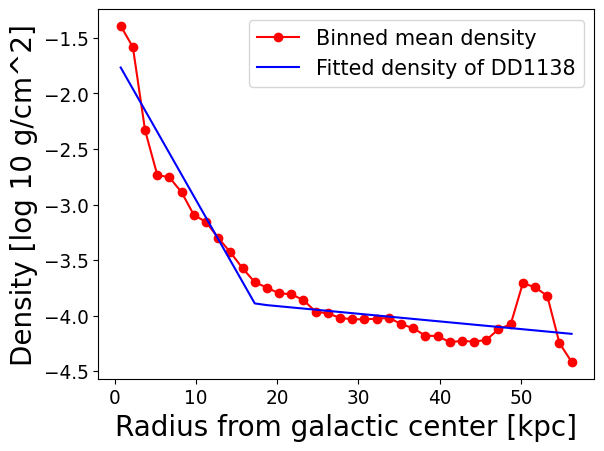

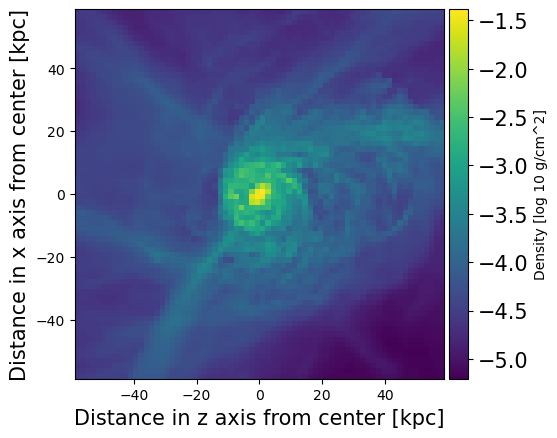

yt : [INFO     ] 2023-07-21 15:18:49,794 Parameters: current_time              = 367.31652781829
yt : [INFO     ] 2023-07-21 15:18:49,795 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:18:49,796 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:18:49,797 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:18:49,797 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:18:49,798 Parameters: current_redshift          = 0.61132831909135
yt : [INFO     ] 2023-07-21 15:18:49,799 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:18:49,800 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:18:49,801 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:18:49,801 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1338/DD1338
get_refine_box: using this location:       col1         col2     col3    col4     col5     col6    col7   col8
---------------- -------- ------- -------- -------- ------- -------- ----
0.61132831909135 0.490681 0.47823 0.505093 0.492681 0.48023 0.507093    9


Parsing Hierarchy : 100%|█████████████████| 6366/6366 [00:00<00:00, 9280.40it/s]
yt : [INFO     ] 2023-07-21 15:18:50,737 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:19:51,942 Projection completed
yt : [INFO     ] 2023-07-21 15:19:51,943 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


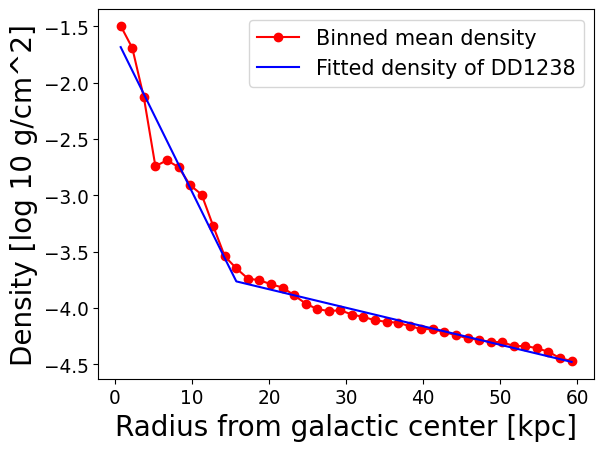

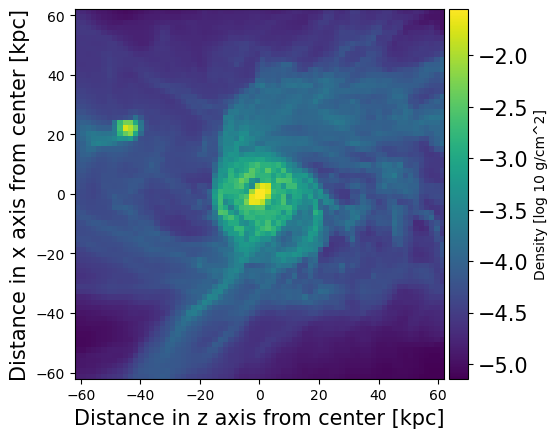

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1438/DD1438


yt : [INFO     ] 2023-07-21 15:19:52,609 Parameters: current_time              = 392.31652781829
yt : [INFO     ] 2023-07-21 15:19:52,610 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:19:52,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:19:52,612 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:19:52,613 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:19:52,614 Parameters: current_redshift          = 0.53034842583426
yt : [INFO     ] 2023-07-21 15:19:52,615 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:19:52,616 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:19:52,617 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:19:52,618 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.53034842583426 0.490464 0.477354 0.505497 0.492464 0.479354 0.507497    9


Parsing Hierarchy : 100%|█████████████████| 6029/6029 [00:00<00:00, 6793.08it/s]
yt : [INFO     ] 2023-07-21 15:19:53,752 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:21:02,492 Projection completed
yt : [INFO     ] 2023-07-21 15:21:02,494 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


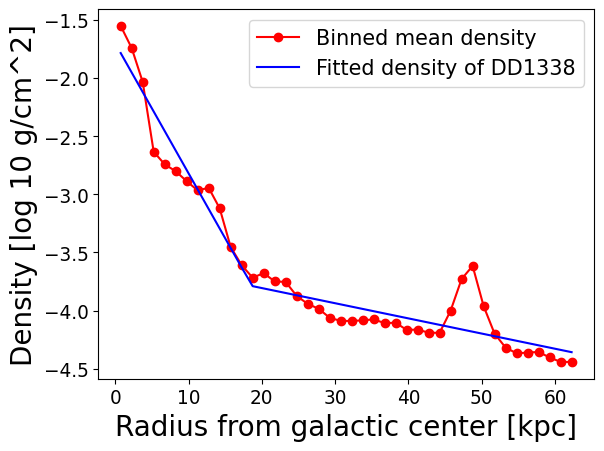

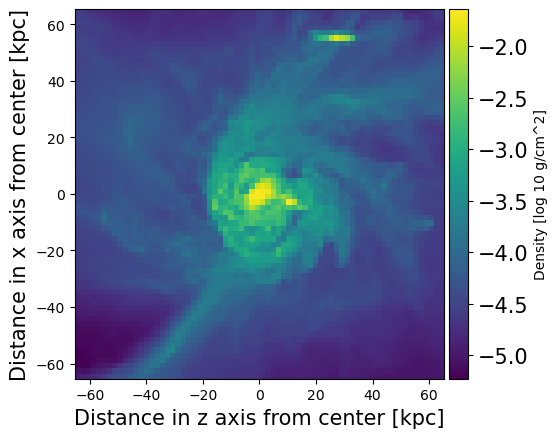

yt : [INFO     ] 2023-07-21 15:21:03,779 Parameters: current_time              = 402.06652781829
yt : [INFO     ] 2023-07-21 15:21:03,780 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:21:03,781 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:21:03,782 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:21:03,782 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:21:03,783 Parameters: current_redshift          = 0.50082158855578
yt : [INFO     ] 2023-07-21 15:21:03,784 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:21:03,785 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:21:03,785 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:21:03,786 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1477/DD1477
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.50082158855578 0.490382 0.477019 0.505663 0.492382 0.479019 0.507663    9


Parsing Hierarchy : 100%|█████████████████| 6066/6066 [00:00<00:00, 7120.89it/s]
yt : [INFO     ] 2023-07-21 15:21:04,928 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:22:16,749 Projection completed
yt : [INFO     ] 2023-07-21 15:22:16,750 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


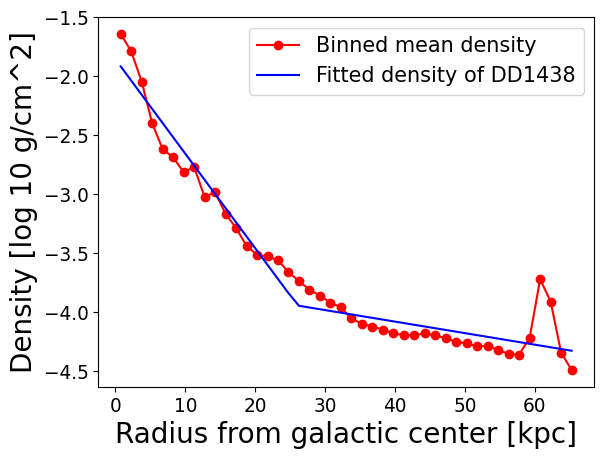

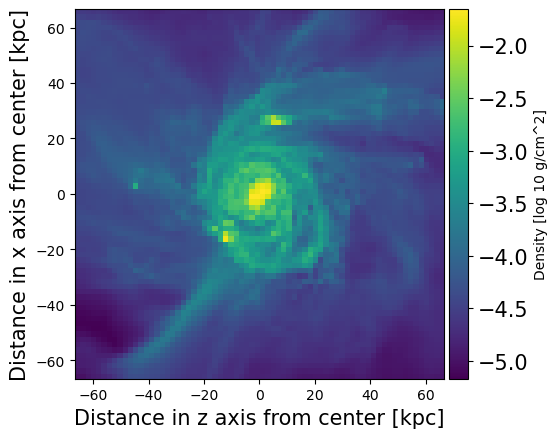

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1478/DD1478


yt : [INFO     ] 2023-07-21 15:22:17,445 Parameters: current_time              = 402.31652781829
yt : [INFO     ] 2023-07-21 15:22:17,447 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:22:17,448 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:22:17,449 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:22:17,450 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:22:17,451 Parameters: current_redshift          = 0.50007848881181
yt : [INFO     ] 2023-07-21 15:22:17,452 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:22:17,452 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:22:17,453 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:22:17,454 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2    col3     col4     col5    col6     col7   col8
---------------- ------- -------- -------- ------- -------- -------- ----
0.50007848881181 0.49038 0.477011 0.505667 0.49238 0.479011 0.507667    9


Parsing Hierarchy : 100%|█████████████████| 5947/5947 [00:00<00:00, 8982.48it/s]
yt : [INFO     ] 2023-07-21 15:22:18,350 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:23:32,824 Projection completed
yt : [INFO     ] 2023-07-21 15:23:32,825 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


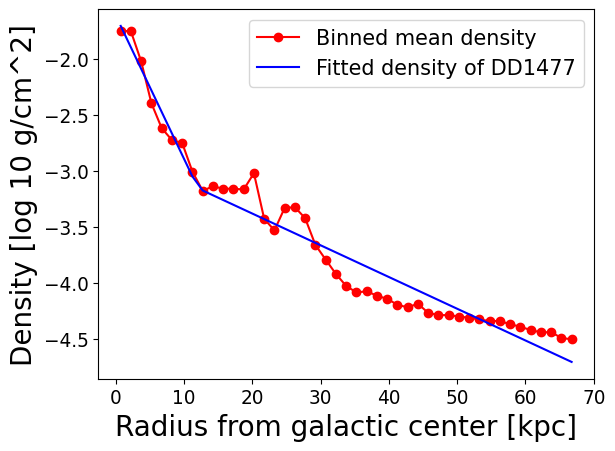

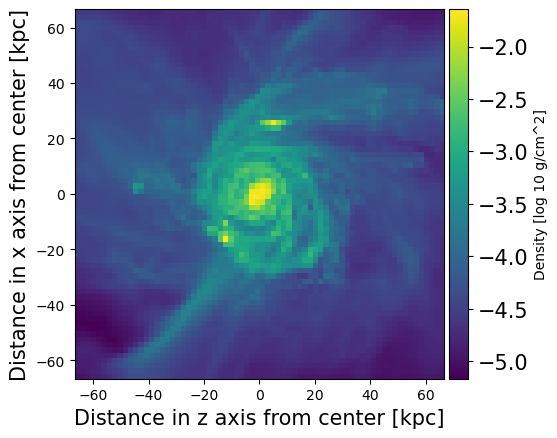

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1479/DD1479


yt : [INFO     ] 2023-07-21 15:23:34,284 Parameters: current_time              = 402.56652517609
yt : [INFO     ] 2023-07-21 15:23:34,285 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:23:34,286 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:23:34,287 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:23:34,288 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:23:34,288 Parameters: current_redshift          = 0.49933608114367
yt : [INFO     ] 2023-07-21 15:23:34,289 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:23:34,290 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:23:34,290 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:23:34,291 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.49933608114367 0.490378 0.477002 0.505671 0.492378 0.479002 0.507671    9


Parsing Hierarchy : 100%|█████████████████| 5985/5985 [00:00<00:00, 6527.79it/s]
yt : [INFO     ] 2023-07-21 15:23:35,540 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:24:50,948 Projection completed
yt : [INFO     ] 2023-07-21 15:24:50,949 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


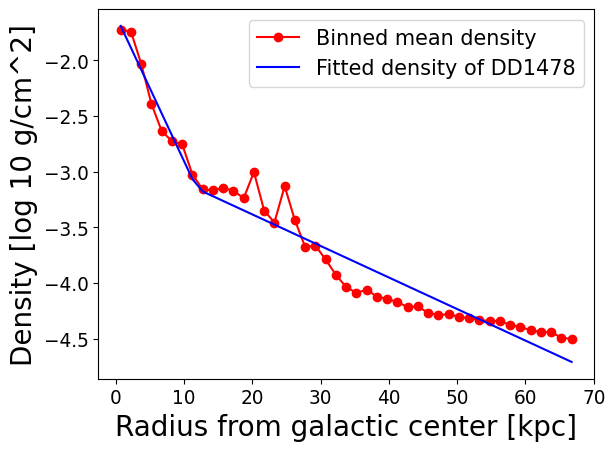

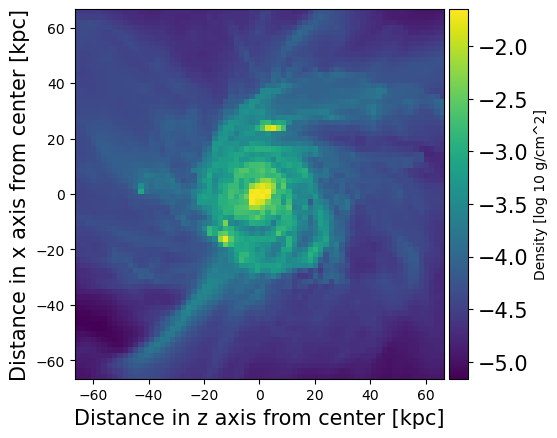

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1538/DD1538


yt : [INFO     ] 2023-07-21 15:24:51,710 Parameters: current_time              = 417.31652781829
yt : [INFO     ] 2023-07-21 15:24:51,710 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:24:51,711 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:24:51,711 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:24:51,712 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:24:51,713 Parameters: current_redshift          = 0.45670560906839
yt : [INFO     ] 2023-07-21 15:24:51,713 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:24:51,714 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:24:51,715 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-07-21 15:24:51,716 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.45670560906839 0.490252 0.476517 0.505875 0.492252 0.478517 0.507875    9


Parsing Hierarchy : 100%|█████████████████| 6119/6119 [00:00<00:00, 8944.49it/s]
yt : [INFO     ] 2023-07-21 15:24:52,651 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:25:47,961 Projection completed
yt : [INFO     ] 2023-07-21 15:25:47,962 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


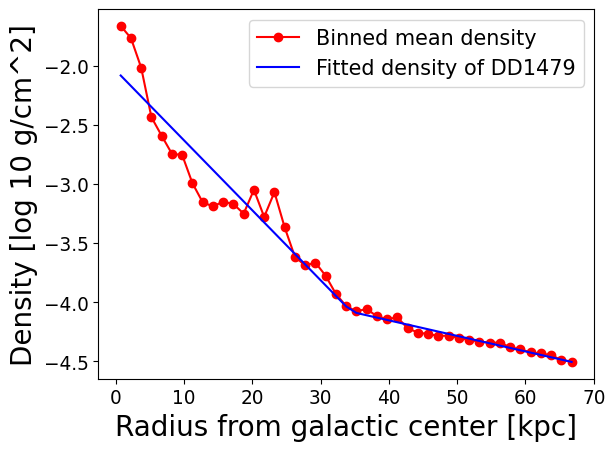

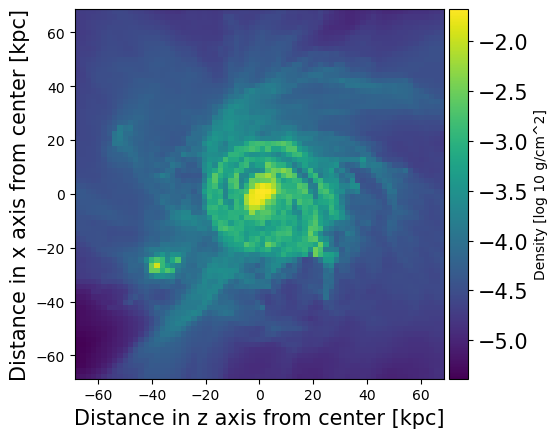

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1638/DD1638


yt : [INFO     ] 2023-07-21 15:25:48,646 Parameters: current_time              = 442.31652781829
yt : [INFO     ] 2023-07-21 15:25:48,647 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:25:48,648 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:25:48,650 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:25:48,651 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:25:48,651 Parameters: current_redshift          = 0.3892837031507
yt : [INFO     ] 2023-07-21 15:25:48,652 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:25:48,653 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:25:48,654 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 15:25:48,654 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.38929394169243 0.490071 0.475697 0.506226 0.492071 0.477697 0.508226    9


Parsing Hierarchy : 100%|█████████████████| 5613/5613 [00:00<00:00, 8354.67it/s]
yt : [INFO     ] 2023-07-21 15:25:49,538 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:26:59,059 Projection completed
yt : [INFO     ] 2023-07-21 15:26:59,060 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


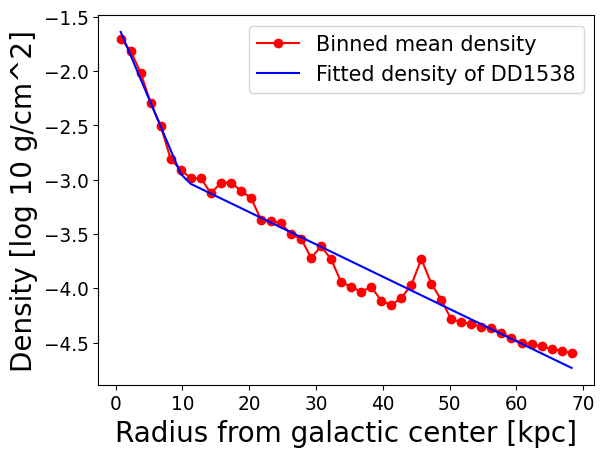

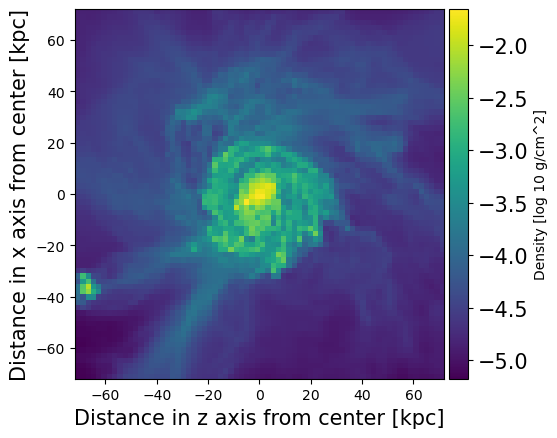

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1738/DD1738


yt : [INFO     ] 2023-07-21 15:26:59,966 Parameters: current_time              = 467.31652781829
yt : [INFO     ] 2023-07-21 15:26:59,967 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:26:59,968 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:26:59,968 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:26:59,969 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:26:59,969 Parameters: current_redshift          = 0.32721407621449
yt : [INFO     ] 2023-07-21 15:26:59,970 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:26:59,971 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:26:59,972 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 15:26:59,972 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.32722883488872 0.489878 0.474896 0.506564 0.491878 0.476896 0.508564    9


Parsing Hierarchy : 100%|█████████████████| 5309/5309 [00:00<00:00, 5919.65it/s]
yt : [INFO     ] 2023-07-21 15:27:01,139 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:28:06,122 Projection completed
yt : [INFO     ] 2023-07-21 15:28:06,124 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


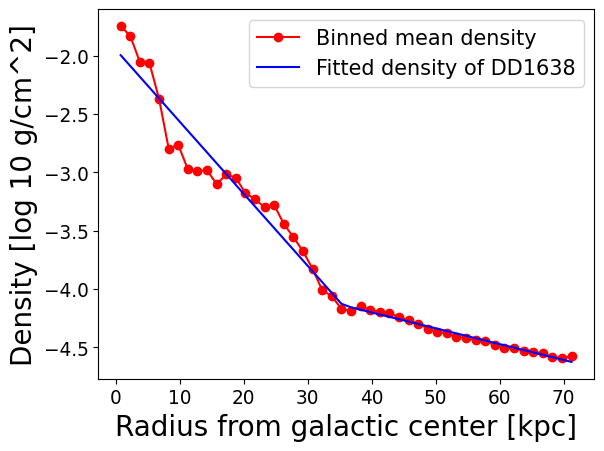

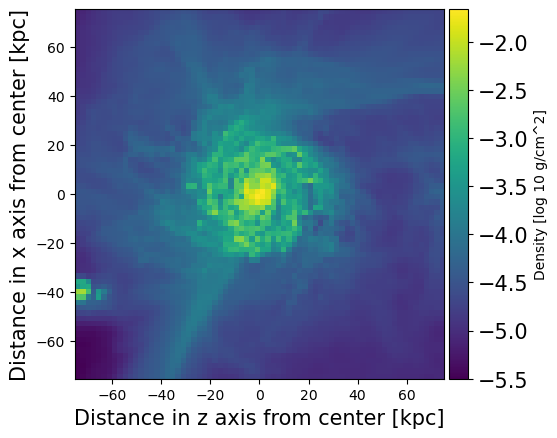

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1838/DD1838


yt : [INFO     ] 2023-07-21 15:28:06,840 Parameters: current_time              = 492.31652781829
yt : [INFO     ] 2023-07-21 15:28:06,840 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:28:06,841 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:28:06,842 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:28:06,843 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:28:06,844 Parameters: current_redshift          = 0.26978215732692
yt : [INFO     ] 2023-07-21 15:28:06,845 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:28:06,845 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:28:06,846 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 15:28:06,847 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1        col2     col3     col4     col5     col6     col7   col8
--------------- -------- -------- -------- -------- -------- -------- ----
0.2697939304999 0.489703 0.474121 0.506863 0.491703 0.476121 0.508863    9


Parsing Hierarchy : 100%|█████████████████| 5365/5365 [00:00<00:00, 6912.93it/s]
yt : [INFO     ] 2023-07-21 15:28:07,846 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:29:11,967 Projection completed
yt : [INFO     ] 2023-07-21 15:29:11,968 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


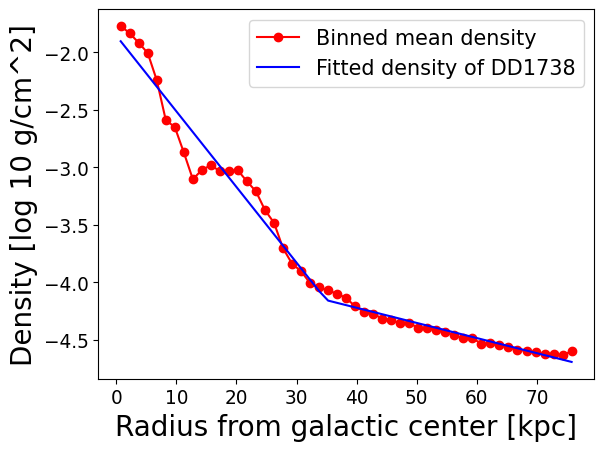

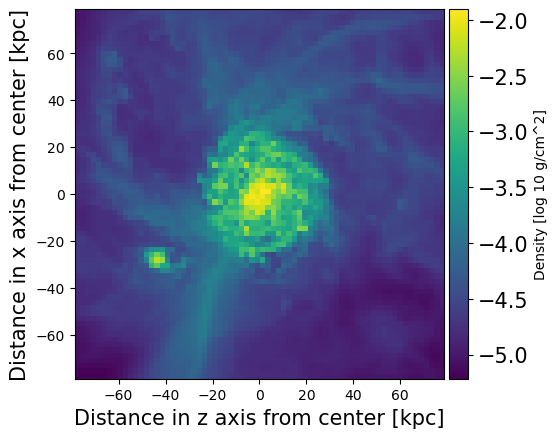

yt : [INFO     ] 2023-07-21 15:29:12,590 Parameters: current_time              = 517.31652781829
yt : [INFO     ] 2023-07-21 15:29:12,590 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:29:12,592 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:29:12,593 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:29:12,593 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:29:12,594 Parameters: current_redshift          = 0.21639444449422
yt : [INFO     ] 2023-07-21 15:29:12,594 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:29:12,595 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:29:12,596 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 15:29:12,596 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD1938/DD1938
get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.21640266677445 0.489548 0.473393 0.507161 0.491548 0.475393 0.509161    9


Parsing Hierarchy : 100%|█████████████████| 4944/4944 [00:00<00:00, 6017.42it/s]
yt : [INFO     ] 2023-07-21 15:29:13,700 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:30:09,623 Projection completed
yt : [INFO     ] 2023-07-21 15:30:09,625 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


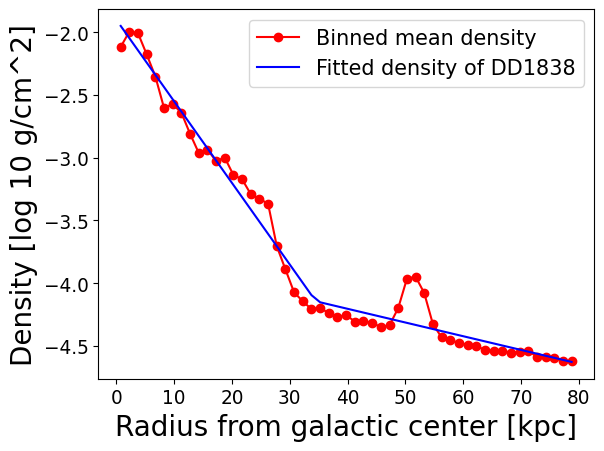

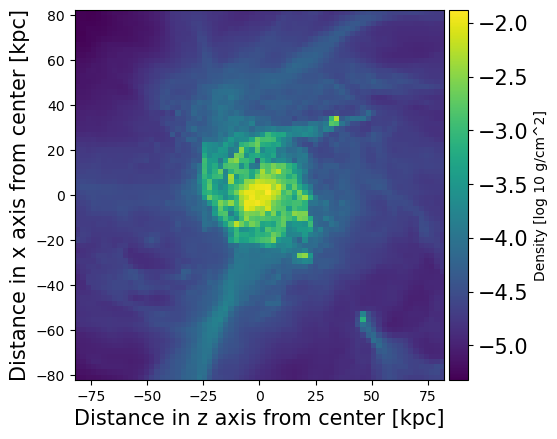

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2038/DD2038


yt : [INFO     ] 2023-07-21 15:30:10,917 Parameters: current_time              = 542.31652781829
yt : [INFO     ] 2023-07-21 15:30:10,918 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:30:10,918 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:30:10,919 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:30:10,920 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:30:10,921 Parameters: current_redshift          = 0.1665627895111
yt : [INFO     ] 2023-07-21 15:30:10,921 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:30:10,922 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:30:10,923 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 15:30:10,924 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.16656997024797 0.489403 0.472708 0.507468 0.491403 0.474708 0.509468    9


Parsing Hierarchy : 100%|█████████████████| 5224/5224 [00:00<00:00, 7171.30it/s]
yt : [INFO     ] 2023-07-21 15:30:11,915 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:31:57,884 Projection completed
yt : [INFO     ] 2023-07-21 15:31:57,885 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


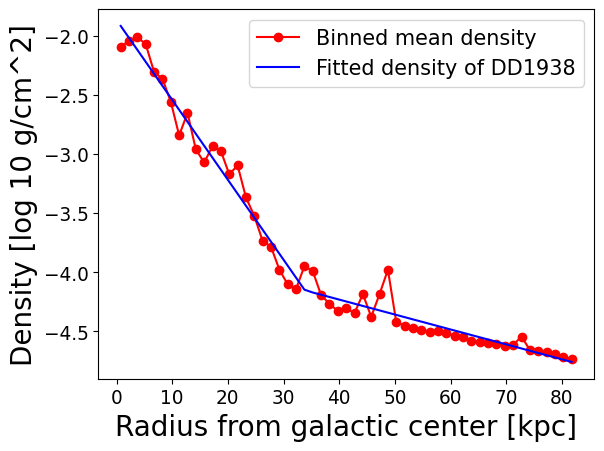

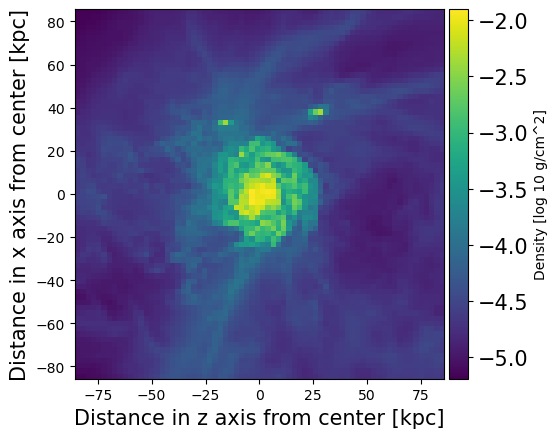

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2138/DD2138


yt : [INFO     ] 2023-07-21 15:31:58,890 Parameters: current_time              = 567.31652781829
yt : [INFO     ] 2023-07-21 15:31:58,890 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:31:58,891 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:31:58,892 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:31:58,893 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:31:58,893 Parameters: current_redshift          = 0.11988207020675
yt : [INFO     ] 2023-07-21 15:31:58,894 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:31:58,895 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:31:58,895 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 15:31:58,896 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:       col1         col2     col3     col4     col5     col6     col7   col8
---------------- -------- -------- -------- -------- -------- -------- ----
0.11989107535193 0.489254 0.472056 0.507771 0.491254 0.474056 0.509771    9


Parsing Hierarchy : 100%|█████████████████| 4682/4682 [00:00<00:00, 6925.79it/s]
yt : [INFO     ] 2023-07-21 15:31:59,804 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:34:12,672 Projection completed
yt : [INFO     ] 2023-07-21 15:34:12,673 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


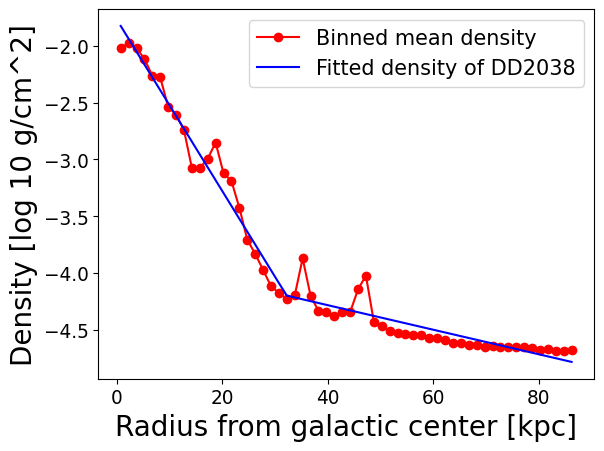

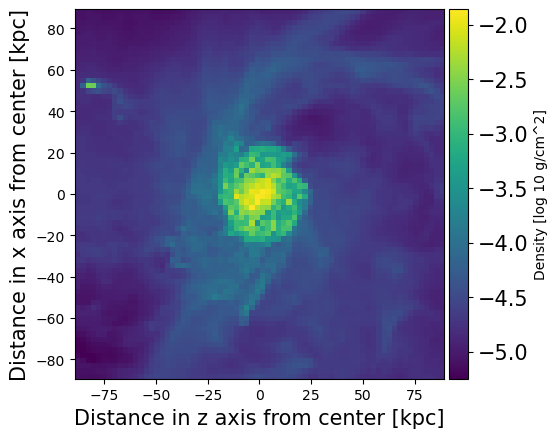

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2238/DD2238


yt : [INFO     ] 2023-07-21 15:34:13,593 Parameters: current_time              = 592.31652781829
yt : [INFO     ] 2023-07-21 15:34:13,594 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:34:13,594 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:34:13,595 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:34:13,596 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:34:13,596 Parameters: current_redshift          = 0.076013204837093
yt : [INFO     ] 2023-07-21 15:34:13,597 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:34:13,598 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:34:13,598 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 15:34:13,599 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.076025451160672 0.489123 0.471432 0.508053 0.491123 0.473432 0.510053    9


Parsing Hierarchy : 100%|█████████████████| 4688/4688 [00:00<00:00, 5684.48it/s]
yt : [INFO     ] 2023-07-21 15:34:14,660 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:36:20,401 Projection completed
yt : [INFO     ] 2023-07-21 15:36:20,402 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70
/Users/hylee/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hylee/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
yt : [INFO     ] 2023-07-21 15:36:20,564 Parameters: current_time              = 604.81652781829
yt : [INFO     ] 2023-07-21 15:36:20,565 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:36:20,565 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:36:20,566 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:36:20,566 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07

Error with DD2238
Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2288/DD2288
get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.055055663741937 0.489056 0.471131 0.508189 0.491056 0.473131 0.510189    9


Parsing Hierarchy : 100%|█████████████████| 4745/4745 [00:00<00:00, 5650.24it/s]
yt : [INFO     ] 2023-07-21 15:36:21,625 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:38:28,261 Projection completed
yt : [INFO     ] 2023-07-21 15:38:28,262 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


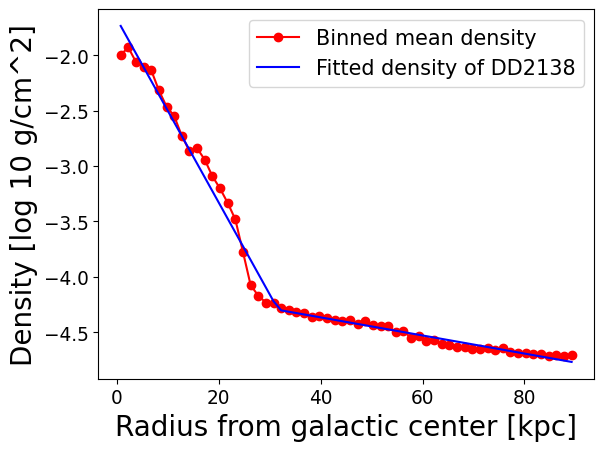

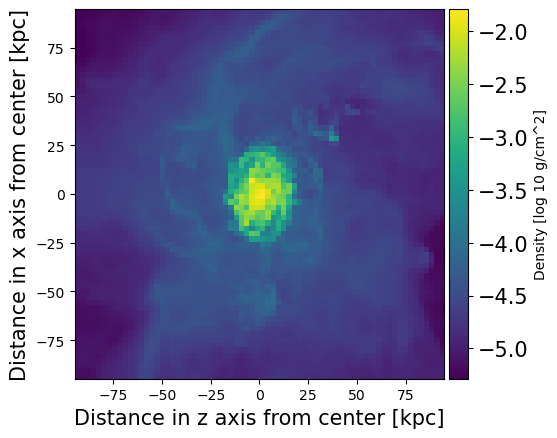

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2289/DD2289


yt : [INFO     ] 2023-07-21 15:38:29,102 Parameters: current_time              = 605.06652781829
yt : [INFO     ] 2023-07-21 15:38:29,103 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:38:29,103 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:38:29,105 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:38:29,106 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:38:29,106 Parameters: current_redshift          = 0.054634911934635
yt : [INFO     ] 2023-07-21 15:38:29,107 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:38:29,108 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:38:29,109 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 15:38:29,109 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4     col5     col6     col7   col8
----------------- -------- -------- -------- -------- -------- -------- ----
0.054642475638284 0.489054 0.471125 0.508191 0.491054 0.473125 0.510191    9


Parsing Hierarchy : 100%|█████████████████| 4798/4798 [00:00<00:00, 6352.35it/s]
yt : [INFO     ] 2023-07-21 15:38:30,073 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:40:29,202 Projection completed
yt : [INFO     ] 2023-07-21 15:40:29,203 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


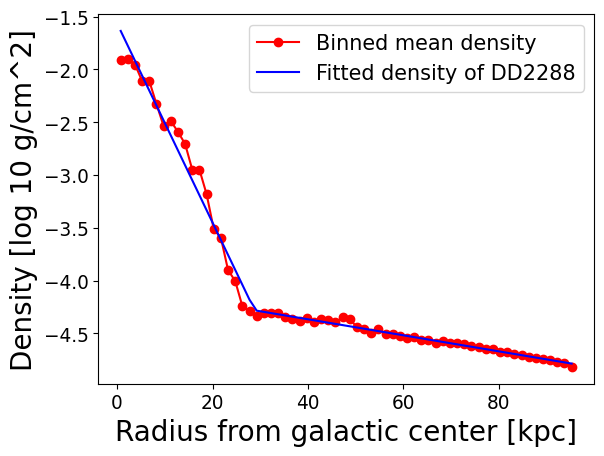

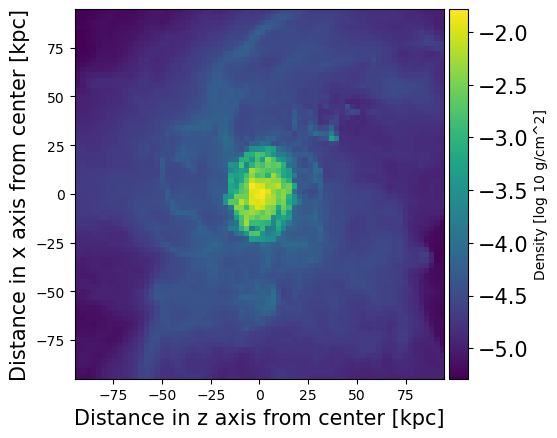

Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2338/DD2338


yt : [INFO     ] 2023-07-21 15:40:29,960 Parameters: current_time              = 617.31652781829
yt : [INFO     ] 2023-07-21 15:40:29,961 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:40:29,962 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:40:29,963 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:40:29,964 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:40:29,965 Parameters: current_redshift          = 0.034670076640073
yt : [INFO     ] 2023-07-21 15:40:29,966 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:40:29,967 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:40:29,968 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 15:40:29,968 Parameters: hubble_constant           = 0.695


get_refine_box: using this location:        col1         col2     col3     col4    col5     col6     col7  col8
----------------- -------- -------- ------- -------- -------- ------- ----
0.034684446722936 0.488987 0.470833 0.50832 0.490987 0.472833 0.51032    9


Parsing Hierarchy : 100%|█████████████████| 4505/4505 [00:00<00:00, 6410.28it/s]
yt : [INFO     ] 2023-07-21 15:40:30,892 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:41:30,370 Projection completed
yt : [INFO     ] 2023-07-21 15:41:30,372 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


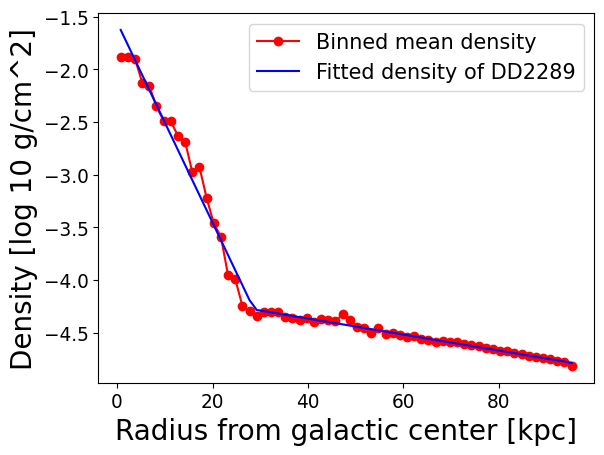

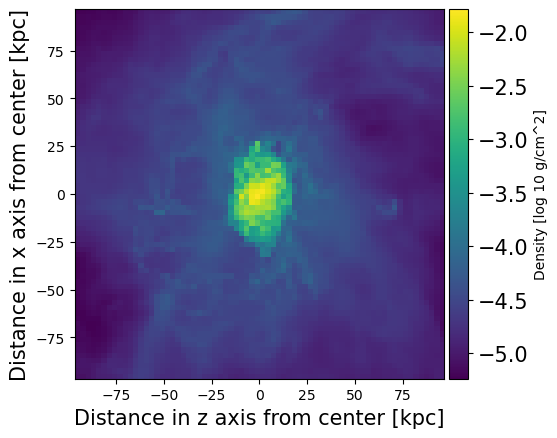

yt : [INFO     ] 2023-07-21 15:41:30,996 Parameters: current_time              = 639.44480357087
yt : [INFO     ] 2023-07-21 15:41:30,996 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2023-07-21 15:41:30,997 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-07-21 15:41:30,998 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-07-21 15:41:30,998 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-07-21 15:41:30,999 Parameters: current_redshift          = 0
yt : [INFO     ] 2023-07-21 15:41:31,000 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2023-07-21 15:41:31,001 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2023-07-21 15:41:31,001 Parameters: omega_radiation           = 0
yt : [INFO     ] 2023-07-21 15:41:31,002 Parameters: hubble_constant           = 0.695


Opening snapshot /Volumes/LaCie/halo_008508/nref11c_nref9f/DD2427/DD2427
get_refine_box: using this location:         col1          col2     col3     col4    col5     col6     col7  col8
------------------- -------- -------- ------- -------- -------- ------- ----
4.4408920985006e-16 0.488865 0.470316 0.50854 0.490865 0.472316 0.51054    9


Parsing Hierarchy : 100%|█████████████████| 4262/4262 [00:00<00:00, 5681.32it/s]
yt : [INFO     ] 2023-07-21 15:41:31,949 Gathering a field list (this may take a moment.)


Pulling halo center from catalog file


yt : [INFO     ] 2023-07-21 15:42:28,985 Projection completed
yt : [INFO     ] 2023-07-21 15:42:28,986 Making a fixed resolution buffer of (('gas', 'density')) 70 by 70


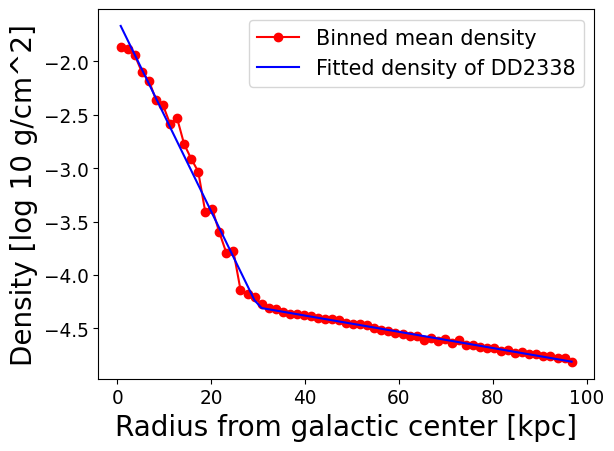

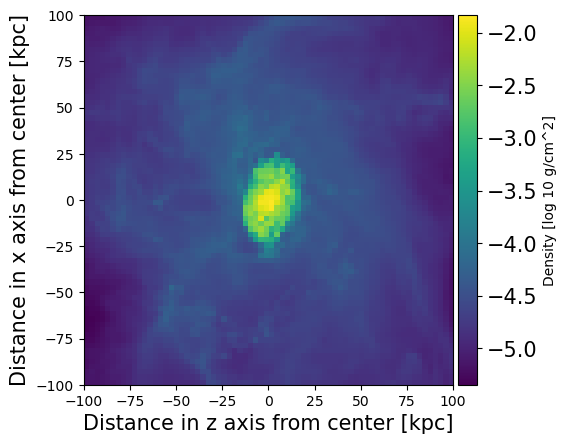

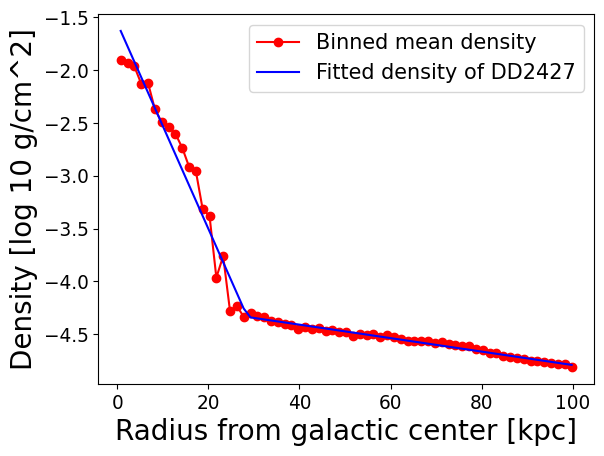

In [8]:
redshiftlist = [] #This part will be replaced with pandas later. 
cutofflist = [] #same 
timelist = [] #same 

for DD in sorted_dd_list:
    try:  
        snap = DD  # name of the snapshot output 
        plotlabel_segment = 'Fitted density of' + " " + snap
        snap_fullpath = simulation_dir + snap + '/' + snap # full path of where the snapshot output lives

        ds, refine_box = foggie_load(snap_fullpath, track_name, halo_c_v_name=track_dir + 'halo_c_v',
                                  disk_relative=False, do_filter_particles=False, masses_dir=track_dir)
        
        z = ds.get_parameter("CosmologyCurrentRedshift")
        current_time = ds.current_time.in_units('Gyr').value
        width = 200/(1+z) #[ckpc/h]
        max_radius = width/2 #[ckpc/h]
        
        #Density cutoff part should be here. 
    
        frb = frb_projection(ds, field, axis, refine_box, width, resolution, weight_field = None)

        OD_Rad, OD_Qua = radius_func(np.array(frb["gas",field]), width, resolution)

        radiuslist, quantitylist =  binning_func(OD_Rad, OD_Qua, max_radius, min_radius, binsize)
        
    
        
        p , e = optimize.curve_fit(piecewise_linear, radiuslist, np.log10(quantitylist), p0 = [20,1,1,1])
        #p : popt(optimization parameter) / e : pcov(covariance of popt)

        projection_plot = projection(frb, field, width, colorlabel, axis, fontsize = 15)
        segment_plot = plotting(radiuslist, np.log10(quantitylist), piecewise_linear(radiuslist, *p),
                        'ro-','b-', plotlabel_linedot, plotlabel_segment)
 
        segment_plot.savefig(output_dir + snap + "_Density_Profile.jpg", bbox_inches = 'tight')
        projection_plot.savefig(output_dir + snap + "_Density_Projection_Plot.jpg")
    
        timepara = ds.current_time.in_units('Gyr').value + 0
        redshiftlist.append(z) #[z]
        cutofflist.append(p[0]) #[kpc]
        timelist.append(timepara) #[Gyr]
        
    except:
        print("Error with" +" "+ snap)
        pass     

In [9]:
#pandadata = {'Rdshift' : redshiftlist, 'Current time' : timelist, 'Cut-off radius' : cutofflist}
#Pd_dataframe = pd.DataFrame(data=d)
#Pd_dataframe4

In [10]:
cutofflist

[14.464798474007278,
 11.760290219736167,
 8.702943138894176,
 8.538432150550339,
 7.116017161602135,
 4.897845859335101,
 8.131125194224294,
 7.391871780105414,
 7.451080712153969,
 7.152319262274247,
 11.663677853166325,
 17.291690045797633,
 15.729736359130044,
 18.67782835816317,
 26.062637776624932,
 12.079597280139607,
 11.920805956006063,
 34.525693579266786,
 10.139327615716148,
 35.46705704003342,
 34.95276090907321,
 34.503295821063666,
 33.84161737101266,
 32.210874248689294,
 31.684911508636826,
 28.81173354242299,
 28.684922093480377,
 29.990302139584255,
 28.570927512450737]

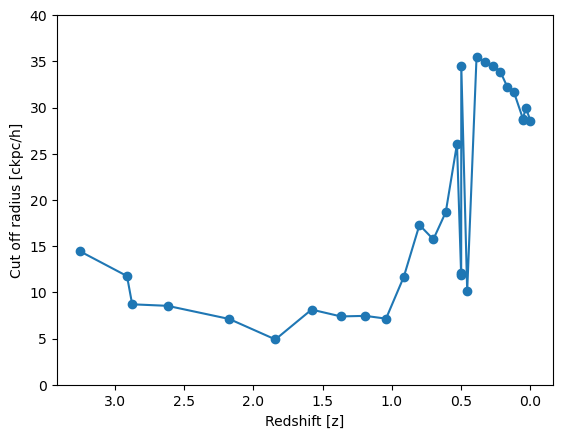

In [11]:
plt.plot(redshiftlist, cutofflist,'-o')
plt.ylabel("Cut off radius [ckpc/h]")
plt.ylim([0,40])
plt.xlabel("Redshift [z]")
plt.gca().invert_xaxis()

In [12]:
cutofflist
#1st, density cut off too aggressive and 2nd, bounds for optimization. no negatifel. 

[14.464798474007278,
 11.760290219736167,
 8.702943138894176,
 8.538432150550339,
 7.116017161602135,
 4.897845859335101,
 8.131125194224294,
 7.391871780105414,
 7.451080712153969,
 7.152319262274247,
 11.663677853166325,
 17.291690045797633,
 15.729736359130044,
 18.67782835816317,
 26.062637776624932,
 12.079597280139607,
 11.920805956006063,
 34.525693579266786,
 10.139327615716148,
 35.46705704003342,
 34.95276090907321,
 34.503295821063666,
 33.84161737101266,
 32.210874248689294,
 31.684911508636826,
 28.81173354242299,
 28.684922093480377,
 29.990302139584255,
 28.570927512450737]

In [13]:
timelist

[1.991808986859407,
 2.255399516439776,
 2.287675907816951,
 2.5297488431457626,
 3.0676886994320105,
 3.605628555718258,
 4.143568412004506,
 4.681508268290753,
 5.219448124577001,
 5.757387980863249,
 6.289948438586634,
 6.827888294872881,
 7.365828151159129,
 7.903768007445377,
 8.441707863731624,
 8.65150440768326,
 8.656883806246125,
 8.6622631479552,
 8.979647720017873,
 9.51758757630412,
 10.055527432590369,
 10.593467288876615,
 11.131407145162862,
 11.66934700144911,
 12.207286857735356,
 13.014196642164729,
 13.019576040727591,
 13.283166570307852,
 13.759313829436067]

In [14]:
redshiftlist

[3.2538800161868,
 2.9116806075987,
 2.8742891413864,
 2.6192132579666,
 2.174064272558,
 1.8407728906142,
 1.5796008591072,
 1.3679320867642,
 1.1918720434881,
 1.0423765498971,
 0.91449134314195,
 0.80131183964773,
 0.70104740107777,
 0.61132831909135,
 0.53034842583426,
 0.50082158855578,
 0.50007848881181,
 0.49933608114367,
 0.45670560906839,
 0.3892837031507,
 0.32721407621449,
 0.26978215732692,
 0.21639444449422,
 0.1665627895111,
 0.11988207020675,
 0.055049291735707,
 0.054634911934635,
 0.034670076640073,
 0]